# Prototype: beta

| Properties      | Data    |
|---------------|-----------|
| *Labels* | `['BENIGN', 'DDoS']` |
| *Normalization* | `Min-Max` |
| *Sample Size* | `10.000`|
| *Adversarial Attack* | `CW` |
| *Explanations* | `SHAP` |


---

In [1]:
# To import modules from the functions directory
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

## Data Preprocessing

In [2]:
import functions.data_preprocessing as dp
import importlib
importlib.reload(dp)

encoding_type = 0 # binary encoding
norm_type = 0 # min-max normalization
label_names = ['BENIGN', 'DDoS'] # labels to include
sample_size = 5000 # sample size for each label -> 2 x sample_size = total samples

dataset = dp.build_dataset(label_names)

normalizer, zero_columns = dp.generate_normalizer(dataset, norm_type)

feature_df, label_df, used_indices = dp.preprocess_data(dataset, encoding_type, normalizer, zero_columns, sample_size=sample_size, random_sample_state=42)
print(label_df.value_counts()) # -> will first show [0, 1] then [1, 0] if label number is equal

-- Building CICIDS2017 dataset --
--- Combining all CICIDS2017 files ---
Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Tuesday-WorkingHours.pcap_ISCX.csv
Wednesday-workingHours.pcap_ISCX.csv
Friday-WorkingHours-Morning.pcap_ISCX.csv
Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Monday-WorkingHours.pcap_ISCX.csv
Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
--- Removing NaN and Infinity values ---
Removing 1358 Rows with NaN values
Removing 1509 Rows with Infinity values
--- Extracting labels ---
 Label
BENIGN    2271320
DDoS       128025
Name: count, dtype: int64
-- Generating normalizer --
--- Splitting labels and features ---
Zero Columns: [' Bwd PSH Flags', ' Bwd URG Flags', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
-- Preprocessing data --
--- Sampling balanced data ---
Sample to shape: (10000, 79)
--- Splitti

## Split Data

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature_df, label_df, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000, 70) (2000, 70) (8000, 2) (2000, 2)


## Create IDS

In [14]:
import functions.intrusion_detection_system as ids
import importlib
importlib.reload(ids)

# build ids with complete dataset
ids_model = ids.build_intrusion_detection_system(X_train, y_train, X_test, y_test)

Epoch 1/10


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8144 - loss: 0.5964 - val_accuracy: 0.9775 - val_loss: 0.2770
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9747 - loss: 0.1938 - val_accuracy: 0.9812 - val_loss: 0.0661
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9803 - loss: 0.0637 - val_accuracy: 0.9837 - val_loss: 0.0508
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9827 - loss: 0.0506 - val_accuracy: 0.9856 - val_loss: 0.0433
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9834 - loss: 0.0445 - val_accuracy: 0.9856 - val_loss: 0.0378
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9835 - loss: 0.0412 - val_accuracy: 0.9862 - val_loss: 0.0341
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9843 - loss: 0.0384 - val_accuracy: 0.9881 - val_loss: 0.0323
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9847 - loss: 0.0367 - val_accuracy: 0.9887 - val_loss: 0.0306
Epo

2025-03-12 10:13:09.001106: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


## Generate Attacks

In [5]:
import functions.attack_generator as ag
import importlib
importlib.reload(ag)

all_features = dataset.drop(columns=[' Label'])
art_model = ag.convert_to_art_model(ids_model, X_train) # TODO: use all features for generating art model

# create smaller dataset
X_train, X_test, y_train, y_test = train_test_split(feature_df, label_df, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

import numpy as np
target_label = np.zeros_like(y_train)
target_label[:, 0] = 1 # desired predicted label = [1, 0] = BENIGN
# print(target_label[:3])

import multiprocessing
num_cores = multiprocessing.cpu_count()

X_adv = ag.generate_cw_attacks_parallel(art_model, X_train, target_label=target_label, num_cores=num_cores)
# print(X_adv_fgsm.iloc[:, :3].head(2))

y_pred_adv = ag.evaluate_art_model(art_model, X_adv, y_train)
print(y_pred_adv.shape)

(8000, 70) (2000, 70) (8000, 2) (2000, 2)
Running attack using 24 CPU cores...

Process 5613 is generating adversarial examples for batch of size 333 
Process 5614 is generating adversarial examples for batch of size 333 
Process 5615 is generating adversarial examples for batch of size 333 
Process 5616 is generating adversarial examples for batch of size 333 
Process 5617 is generating adversarial examples for batch of size 333 
Process 5618 is generating adversarial examples for batch of size 333 




Process 5619 is generating adversarial examples for batch of size 333 

Process 5620 is generating adversarial examples for batch of size 333 


Process 5621 is generating adversarial examples for batch of size 333 

Process 5622 is generating adversarial examples for batch of size 333 
Process 5623 is generating adversarial examples for batch of size 333 

Process 5624 is generating adversarial examples for batch of size 333 
Process 5625 is generating adversarial examples for batch o

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/341 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

Accuracy: 76.02%
              precision    recall  f1-score   support

      BENIGN       0.68      1.00      0.81      3988
      ATTACK       1.00      0.52      0.69      4012

   micro avg       0.76      0.76      0.76      8000
   macro avg       0.84      0.76      0.75      8000
weighted avg       0.84      0.76      0.75      8000
 samples avg       0.76      0.76      0.76      8000

Confusion Matrix: Positive == BENIGN
TN: 2094, FP: 1918, FN: 0, TP: 3988
(8000, 2)


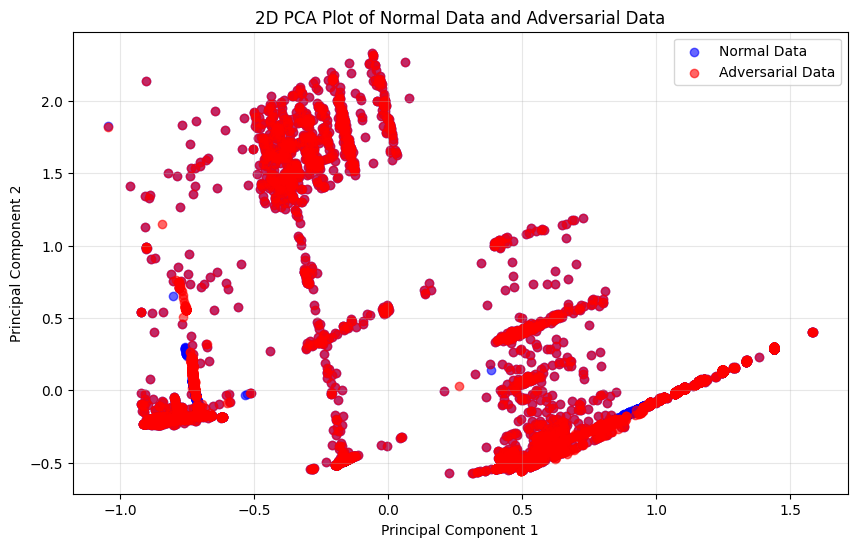

In [ ]:
import functions.visualizer as visualizer
import importlib
importlib.reload(visualizer)

visualizer.visualize_data_distribution(X_train, 'Normal Data', X_adv, 'Adversarial Data')

## Explainer

In [ ]:
import functions.explainer as exp
import importlib
importlib.reload(exp)

explainer = exp.generate_shap_explainer(ids_model, X_train)

shap_values_df = exp.generate_shap_values(explainer, X_train)
print(shap_values_df.shape)

shap_values_adv_df = exp.generate_shap_values(explainer, X_adv)
print(shap_values_adv_df.shape)

PermutationExplainer explainer: 8001it [04:06, 31.57it/s]                          


(8000, 70)


PermutationExplainer explainer: 8001it [04:14, 30.34it/s]                          


(8000, 70)


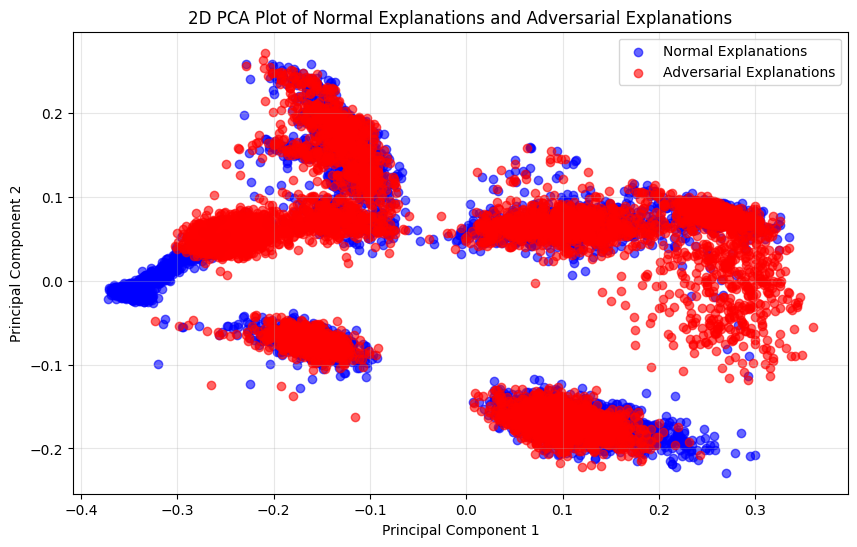

In [12]:
visualizer.visualize_data_distribution(shap_values_df, 'Normal Explanations', shap_values_adv_df, 'Adversarial Explanations')

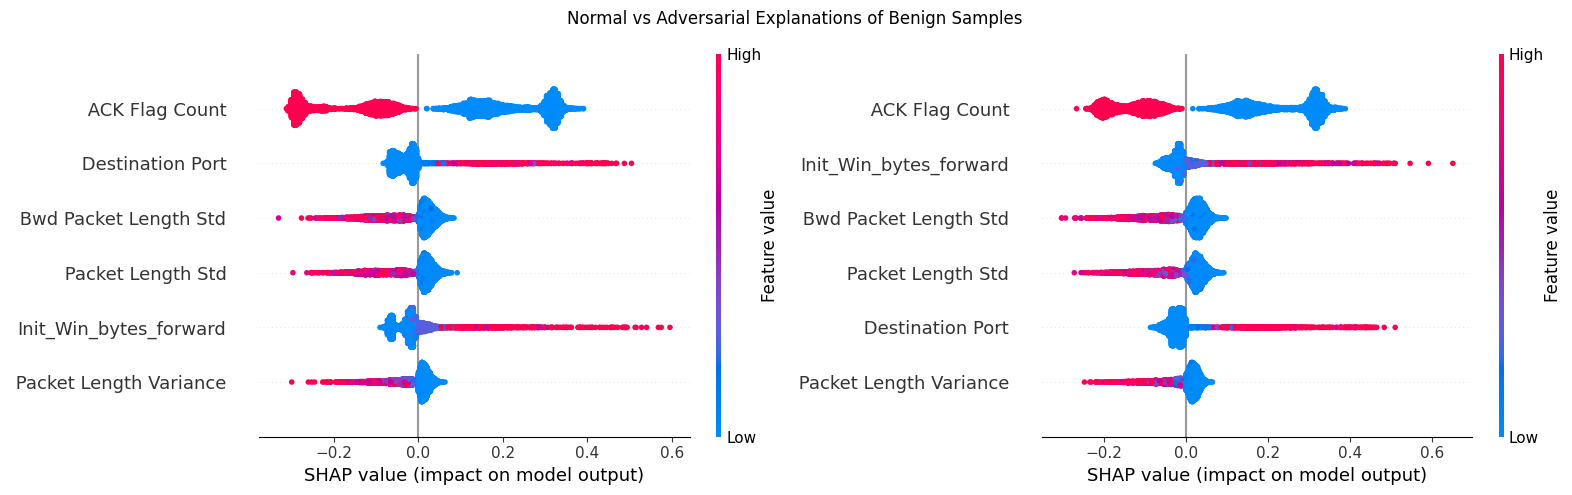

In [ ]:
exp.plot_shap_summary_comparison(shap_values_df.values, X_train, shap_values_adv_df.values, X_adv, 6, title='Normal vs Adversarial Explanations of Benign Samples')

## Detector

In [ ]:
import functions.detector as det
import importlib
importlib.reload(det)

# create dataframe
class_samples = {
    'BENIGN': shap_values_df,
    'ADVERSARIAL': shap_values_adv_df,
}
X, y = det.build_detector_dataset(class_samples)
print(X.shape, y.shape)

# split data
X_train_det, X_test_det, y_train_det, y_test_det = train_test_split(X, y, test_size=0.1, random_state=1503)
print(X_train_det.shape, X_test_det.shape, y_train_det.shape, y_test_det.shape)

# build detector
detector = det.build_detector(X_train_det, y_train_det, X_test_det, y_test_det)

(16000, 70) (16000, 2)
(14400, 70) (1600, 70) (14400, 2) (1600, 2)
Epoch 1/10


2025-03-12 10:13:41.388352: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5901 - loss: 0.6863 - val_accuracy: 0.6187 - val_loss: 0.6442
Epoch 2/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6315 - loss: 0.6311 - val_accuracy: 0.6299 - val_loss: 0.5809
Epoch 3/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6171 - loss: 0.5860 - val_accuracy: 0.6292 - val_loss: 0.5550
Epoch 4/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6232 - loss: 0.5608 - val_accuracy: 0.6274 - val_loss: 0.5443
Epoch 5/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6233 - loss: 0.5513 - val_accuracy: 0.6267 - val_loss: 0.5401
Epoch 6/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6346 - loss: 0.5448 - val_accuracy: 0.6222 - val_loss: 0.5363
Epoch 7/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6276 - loss: 0.5429 - val_accuracy: 0.6222 - val_loss: 0.5350
Epoch 8/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6279 - loss: 0.5406 - val_accuracy: 0.6177 - val_

### Comparator - Normal Detector: Based on Raw Data

In [ ]:
class_samples = {
    'BENIGN': X_train,
    'ADVERSARIAL': X_adv,
}
X, y = det.build_detector_dataset(class_samples)
print(X.shape, y.shape)

X_train_det, X_test_det, y_train_det, y_test_det = train_test_split(X, y, test_size=0.1, random_state=1503)
print(X_train_det.shape, X_test_det.shape, y_train_det.shape, y_test_det.shape)

# build detector
detector = det.build_detector(X_train_det, y_train_det, X_test_det, y_test_det)

(16000, 70) (16000, 2)
(14400, 70) (1600, 70) (14400, 2) (1600, 2)
Epoch 1/10


2025-03-12 10:13:50.783307: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5306 - loss: 0.6916 - val_accuracy: 0.5847 - val_loss: 0.6793
Epoch 2/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5797 - loss: 0.6731 - val_accuracy: 0.5983 - val_loss: 0.6308
Epoch 3/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6126 - loss: 0.6283 - val_accuracy: 0.6104 - val_loss: 0.5902
Epoch 4/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6148 - loss: 0.5989 - val_accuracy: 0.6253 - val_loss: 0.5713
Epoch 5/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6135 - loss: 0.5798 - val_accuracy: 0.6163 - val_loss: 0.5615
Epoch 6/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6289 - loss: 0.5691 - val_accuracy: 0.6243 - val_loss: 0.5539
Epoch 7/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6233 - loss: 0.5624 - val_accuracy: 0.6097 - val_loss: 0.5506
Epoch 8/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6326 - loss: 0.5567 - val_accuracy: 0.6153 - val_

---
## Test Process

In [53]:
print(X_test.shape)

(800, 70)


### Generate Attacks

In [54]:
X_test_adv = ag.generate_fgsm_attacks(art_model, X_test)

Adversarial FGSM examples generated. Shape: (800, 70)


### Generate Explanations

In [ ]:
X_test_adv_shap_values_df = exp.generate_shap_values(explainer, X_test_adv)
X_test_shap_values_df = exp.generate_shap_values(explainer, X_test)

PermutationExplainer explainer: 801it [00:49, 12.77it/s]                         
PermutationExplainer explainer: 801it [00:53, 12.15it/s]                         


### Generate Datasets

In [ ]:
class_samples = {
    'BENIGN': X_test_shap_values_df,
    'ADVERSARIAL': X_test_adv_shap_values_df,
}
X, y = det.build_detector_dataset(class_samples)
X, y = det.build_train_datasets(X_test_shap_values_df, X_test_adv_shap_values_df)

### Preprocess Data

In [57]:
# print(np.max(X))
# print(np.min(X))
# X = normalizer.transform(X)
# print(np.max(X))
# print(np.min(X))

### Shuffle Data & Predict

In [58]:
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=187)

y_pred = detector.predict(X)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


### Evaluate

In [59]:
det.evaluate_model(y_pred, y)

Global Accuracy: 99.69%
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00       800
 ADVERSARIAL       1.00      1.00      1.00       800

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600

True Negative Rate: 99.62%
False Positive Rate: 0.38%
True Positive Rate: 99.75%
False Negative Rate: 0.25%


---
## Additional Evaluation - New Samples

In [60]:
import functions.data_preprocessing as dp
import importlib
importlib.reload(dp)

X_eval, y_eval = dp.preprocess_data(dataset, encoding_type, normalizer, zero_columns, sample_size=500, random_sample_state=17)
print(y_eval.value_counts())

-- Preprocessing data --
--- Sampling balanced data ---
Sample to shape: (1000, 79)
--- Splitting labels and features ---
--- Encoding labels as binary one-hot values ---
--- Normalizing features using MinMaxScaler ---
BENIGN  ATTACK
False   True      500
True    False     500
Name: count, dtype: int64


In [ ]:
X_adv_fgsm_eval = ag.generate_fgsm_attacks(art_model, X_eval)
print(X_adv_fgsm_eval.iloc[:, :3].head(2))

ag.evaluate_art_model(art_model, X_adv_fgsm_eval, y_eval)

Adversarial FGSM examples generated. Shape: (1000, 70)
   Destination Port  Flow Duration  Total Fwd Packets
0          0.101221            0.0           0.100018
1          0.000000            0.0           0.000000
Accuracy: 0.177
              precision    recall  f1-score   support

      BENIGN       0.22      0.25      0.24       500
      ATTACK       0.12      0.10      0.11       500

   micro avg       0.18      0.18      0.18      1000
   macro avg       0.17      0.18      0.17      1000
weighted avg       0.17      0.18      0.17      1000
 samples avg       0.18      0.18      0.18      1000

Confusion Matrix: Positive == BENIGN
TN: 50, FP: 450, FN: 373, TP: 127


0.177

In [ ]:
X_eval_adv_shap_values_df = exp.generate_shap_values(explainer, X_adv_fgsm_eval)
X_eval_shap_values_df = exp.generate_shap_values(explainer, X_eval)

PermutationExplainer explainer: 1001it [00:57, 14.61it/s]                          
PermutationExplainer explainer: 1001it [01:03, 13.27it/s]                          


In [ ]:
class_samples = {
    'BENIGN': X_eval_shap_values_df,
    'ADVERSARIAL': X_eval_adv_shap_values_df,
}
X_eval_detector, y_eval_detector = det.build_detector_dataset(class_samples)
print(X_eval_detector.shape, y_eval_detector.shape)

(2000, 70) (2000, 2)


In [64]:
from sklearn.utils import shuffle

X_eval_detector, y_eval_detector = shuffle(X_eval_detector, y_eval_detector, random_state=187)

y_pred_eval_detector = detector.predict(X_eval_detector)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [65]:
det.evaluate_model(y_pred_eval_detector, y_eval_detector)

Global Accuracy: 99.60%
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00      1000
 ADVERSARIAL       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

True Negative Rate: 99.60%
False Positive Rate: 0.40%
True Positive Rate: 99.60%
False Negative Rate: 0.40%
